In [5]:
import distributedAcceleratedGradient as algo
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from tqdm.notebook import tqdm

In [30]:
### Plot params
def my_rc_params(magnifier=1):
    plt.style.use(["seaborn-deep"])
    plt.rcParams['axes.labelsize'] =12*magnifier
    plt.rcParams['xtick.labelsize'] = 12*magnifier
    plt.rcParams['ytick.labelsize'] = 12*magnifier
    plt.rcParams['legend.fontsize'] = 10*magnifier
    plt.rcParams['lines.linewidth'] = 1.5*magnifier
    plt.rcParams['figure.figsize'] = 12, 6
    plt.rc('text', usetex=True)    
my_rc_params(3) 

## The robustness problem

In [7]:
def disturbance(t, epsilon = 1e-3, period = 1e4, n = 4):
    #signDisturbance = np.ones((n, 1))
    signDisturbance = (1-2*int(((t%period)/period)>0.5))*np.ones((n, 1))
    assert n%2 == 0
    signDisturbance[n//2:] *= -1
    return epsilon*signDisturbance

In [8]:
tspan = [0, 8e4 ]
tmin, tmax = 0.1, 35
dt = 5e-2
nAgents = 2
p = 2 # Dimension of the primal decision variable
A = algo.ALine(nAgents)
L = algo.LaplLine(nAgents)
bigL = np.kron(L, np.eye(p))
zstar = lambda z: z
gamma = 1/4


### Flow map for regular algorithm perturbed
Fquad = partial(algo.FAcc, L = bigL, zstar = zstar,
                         n = nAgents, p = p, gamma = gamma, disturbance = disturbance)
### Synching jump map
rvec = np.array([(tmax - tmin)/(nAgents + 1) + tmin]*nAgents).reshape(-1, 1)

Gquadx1tox2 = partial(algo.GAcc, tmin = tmin, tmax = tmax,
                        rvec = rvec , A = A, n = nAgents, p = p, strong = 2)                        
### Flow and jump checks
checkFlow = partial(algo.checkFlowSyncAcc, tmin = tmin, tmax = tmax, n = nAgents, p = p)
checkJump = partial(algo.checkJumpSyncAcc, tmin = tmin, tmax = tmax, n = nAgents, p = p)

tmax = tspan[1] + 10
def GnoReset(x):
    raise Exception('The system should not be jumping.')               
### Flow and jump checks
checkFlowNoReset = partial(algo.checkFlowSyncAcc, tmin = tmin, tmax = tmax, n = nAgents, p = p)
checkJumpNoReset = partial(algo.checkJumpSyncAcc, tmin = tmin, tmax = tmax, n = nAgents, p = p)

In [10]:

x2_0 = 0.01*np.ones((nAgents*p, 1))
x2_0[2:] = -0.01
x1_0 = x2_0.copy()
assert np.ones((nAgents*p,1)).T@x2_0 == 0
t0 = tmin*np.ones((nAgents, 1))##in sync
x0 = np.vstack([x1_0, x2_0, t0])
sol = algo.rk4HybridSyncClocksAcc(Fquad, GnoReset, tspan,
                              x0, dt, checkFlowNoReset, checkJumpNoReset, tqdm=tqdm)

In [11]:
np.save('non_reset_disturbance.npy', sol)

In [12]:
def get_primal_variables(y, n, p, bigL, zstar):
    x = y[:,:n*p,:]    
    primalDistCostReg = lambda x: 0.5*x.T@x
    zFromDual = zstar
    zHist = np.array([zFromDual(xi) for xi in tqdm(x, desc= 'Primal Vars')])
    zHist = zHist.reshape(*zHist.shape[:-1])
    Fstar = primalDistCostReg(np.kron(np.ones((n, 1)), np.zeros((n*p, 1))))
    costDifference = np.array([primalDistCostReg(z) - Fstar for z in tqdm(zHist, desc = 'Cost Difference')])
    consensusDistance = np.array([np.linalg.norm(bigL@z) for z in tqdm(zHist, desc = 'Consensus Distance')])
    return costDifference, consensusDistance, zHist

In [13]:
cost, distance, zhist = get_primal_variables(sol.y, nAgents, p, bigL, zstar)

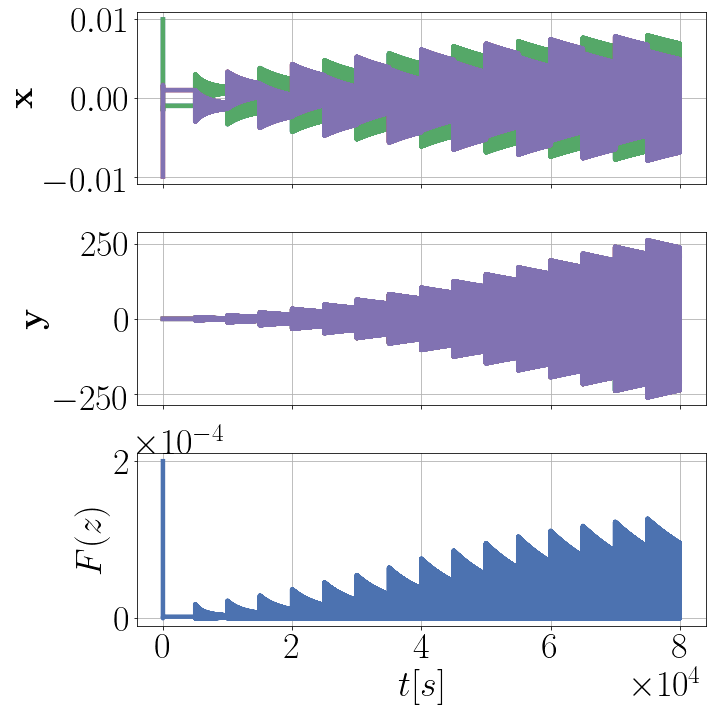

In [32]:
fig, axarr = plt.subplots(3, 1, figsize = (10, 10 ), sharex = True)
ax = axarr[0]
ax.plot(sol.t[:, 0], sol.y[:,:nAgents*p,:].squeeze())
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.grid()
ax.set_ylabel(r'$\mathbf{x}$')

ax = axarr[1]
ax.plot(sol.t[:, 0], sol.y[:, nAgents*p: 2*nAgents*p,:].squeeze())
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.grid()
ax.set_ylabel(r'$\mathbf{y}$')


ax = axarr[2]
ax.plot(sol.t[:, 0], cost.squeeze())
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.grid()
ax.set_ylabel(r'$F(z)$')
ax.set_xlabel(r'$t[s]$')
plt.tight_layout()
plt.savefig('non_reset_disturbance.png', bbox_inches = 'tight')

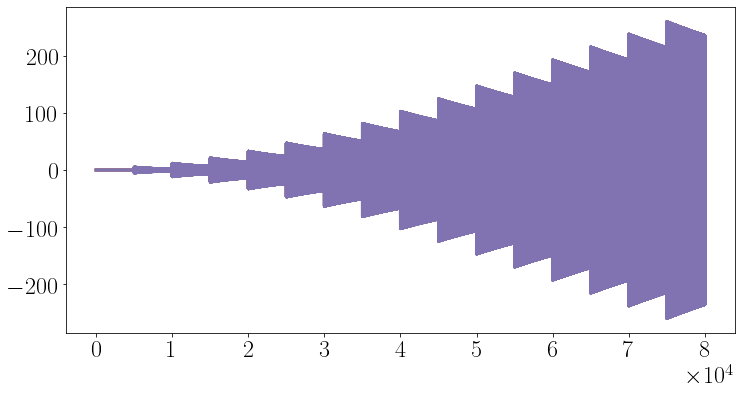

In [19]:
plt.plot(sol.t[:, 0], sol.y[:,nAgents*p:2*nAgents*p,:].squeeze())
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

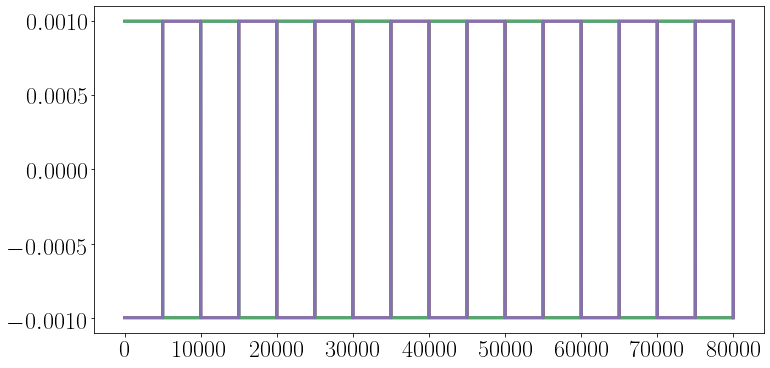

In [20]:
plt.plot(sol.t[:, 0], np.squeeze([disturbance(t) for t in sol.t[:, 0]]))

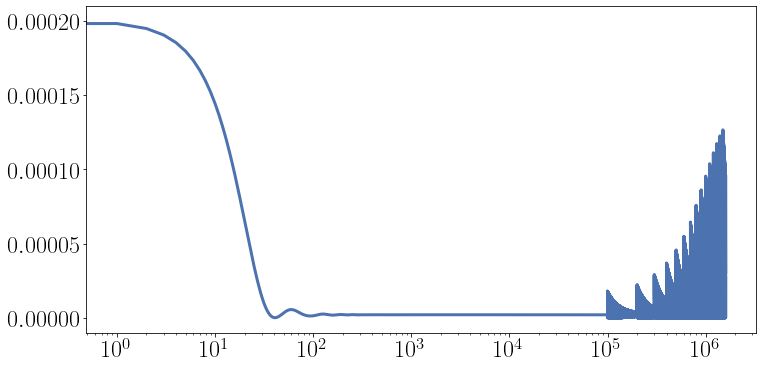

In [21]:
plt.semilogx(cost.squeeze())

In [22]:
t0 = tmin*np.ones((nAgents, 1))##in sync
x0 = np.vstack([x1_0, x2_0, t0])
solReset = algo.rk4HybridSyncClocksAcc(Fquad, Gquadx1tox2, tspan,
                              x0, dt, checkFlow, checkJump, tqdm=tqdm)

In [23]:
np.save('reset_disturbance.npy', solReset)

In [24]:
costReset, distance, zhist = get_primal_variables(solReset.y, nAgents, p, bigL, zstar)

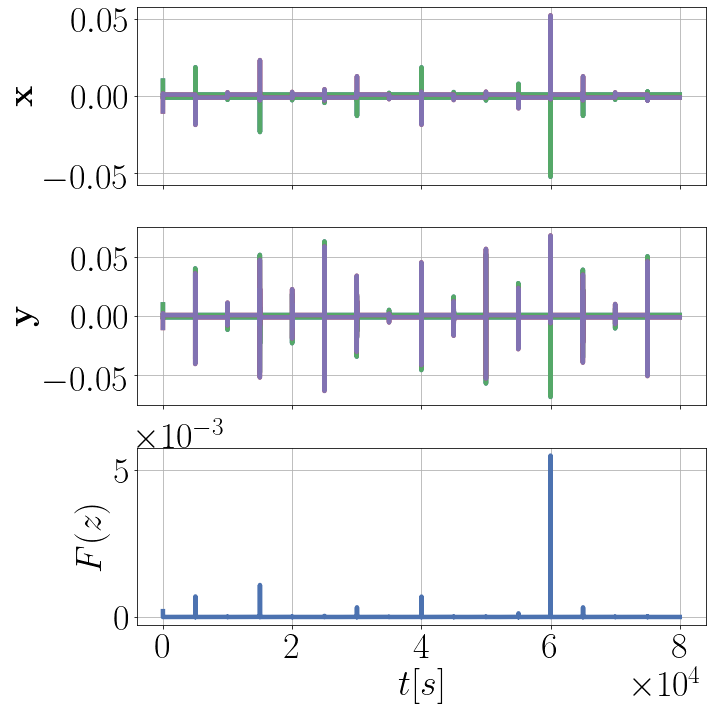

In [33]:
fig, axarr = plt.subplots(3, 1, figsize = (10, 10 ), sharex = True)
ax = axarr[0]
ax.plot(solReset.t[:, 0], solReset.y[:,:nAgents*p,:].squeeze())
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.grid()
ax.set_ylabel(r'$\mathbf{x}$')

ax = axarr[1]
ax.plot(solReset.t[:, 0], solReset.y[:, nAgents*p: 2*nAgents*p,:].squeeze())
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.grid()
ax.set_ylabel(r'$\mathbf{y}$')


ax = axarr[2]
ax.plot(solReset.t[:, 0], costReset.squeeze())
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax.grid()
ax.set_ylabel(r'$F(z)$')
ax.set_xlabel(r'$t[s]$')
plt.tight_layout()
plt.savefig('reset_disturbance.png', bbox_inches = 'tight', dpi = 400)